In [19]:
%matplotlib inline


# Possesion Chains
Create Possesion Chains


In [20]:
import pandas as pd
import numpy as np
import json
# plotting
import os
import pathlib
import warnings 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mplsoccer import Pitch
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

## Opening the dataset

First we open the data. It is exactly the same way as we did earlier. However, this time 
we reset the index to have the indicies sorted.



In [40]:
df = pd.DataFrame()


file_name = 'events_England' +  '.json'
path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'data', 'Wyscout', file_name)
with open(path) as f:
    data = json.load(f)
df = pd.DataFrame(data)

In [41]:
len(df)

643150

## Preparing data 

First we see create a new column with the next event. We create a column with 1 if the ball
was kicked out - to mark when the chain should be stopped. **We filter out *Interruptions* since
there was an ball out of the pitch or foul before them**. Then, we filter lost duels, since **Wyscout
duels are saved twice** - for both team either defensive or offensive. We filter out
events "Out of ball" since we can get this information from other column. Then, we filter 
out events by goalkeepers, since shots were made before. 

In [22]:
next_event = df.shift(-1, fill_value=0)
df["nextEvent"] = next_event["subEventName"]
df["kickedOut"] = df.apply(lambda x: 1 if x.nextEvent == "Ball out of the field" else 0, axis = 1)

#interruptions out
interruption = df.loc[df["eventName"] == "Interruption"]
#probably need to drop "others on the ball event" - nope

# filter out non-accurate duels - in wyscout they are 2 way - attacking and defending
lost_duels = df.loc[df["eventName"] == "Duel"]
lost_duels = lost_duels.loc[lost_duels.apply (lambda x:{'id':1802} in x.tags, axis = 1)]
df = df.drop(lost_duels.index)

# filter ball out of the field - I can get this anyways
out_of_ball = df.loc[df["subEventName"] == "Ball out of the field"]
df = df.drop(out_of_ball.index)

# save attempts can be dropped
goalies = df.loc[df["subEventName"].isin(["Goalkeeper leaving line", "Save attempt", "Reflexes"])]
df = df.drop(goalies.index)

## Isolating possesion chain

Then, we isolate possesion chain with the rule that **if the ball was touched once by 
a different team, it should not change the results**. If there was a **foul, ball kicked out
of the field the chain is stopped**. For others in the ball, if the ball was properly intercepted
that is, the next team is the one that made the next event, we stop the chain. Otherwise,
if the ball was only touched, but did not change possesion, we treat a pass as an accurate one.
Note that this is an approximate of true possesion chain. In the industry you will work
on datasets with possesion chains already isolated.

In [23]:
def isolateChains(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    df: dataframe
        dataframe with isolated possesion chains

    """
    #Find the team present in the next action
    df["nextTeamId"] = df.shift(-1, fill_value=0)["teamId"]
    #potential +0s
    chain_team = df.iloc[0]["teamId"]
    period = df.iloc[0]["matchPeriod"]
    stop_criterion = 0
    chain = 0
    df["possesion_chain"] = 0
    df["possesion_chain_team"] = 0
    
    for i, row in df.iterrows():
        #add value
        df.at[i, "possesion_chain"] = chain
        df.at[i, "possesion_chain_team"] = chain_team
        # if pass not accurate/lost duel, add 1 to stop criterion
        if row["eventName"] == "Pass" or row["eventName"] == "Duel":
            #1802 == Not accurate
            if row["teamId"] == chain_team and {"id": 1802} in row["tags"]:
                    stop_criterion += 1
            # 1801 == Accurate, and row is not the same team
            if row["teamId"] != chain_team and {"id": 1801} in row["tags"]:
                    stop_criterion += 1   
        #if ball intercepted properly add 2            
        if row["eventName"] == "Others on the ball":
               if row["teamId"] == row["nextTeamId"]:
                   stop_criterion += 2
        #if shot, add 2 to stop criteriom        
        if row["eventName"] in ["Shot", "Foul", "Offside"]:
                stop_criterion += 2
        #if ball out of field, add 2
        if row["kickedOut"] == 1:
                stop_criterion += 2
        #criterion for stopping when half ended
        if row["matchPeriod"] != period:
                chain += 1
                stop_criterion = 0
                chain_team = row['teamId']
                period = row["matchPeriod"] 
                df.at[i, "possesion_chain"] = chain
                df.at[i, "possesion_chain_team"] = chain_team
        #possesion chain ended
        if stop_criterion >= 2:
            chain += 1
            stop_criterion = 0
            chain_team = row['nextTeamId']
    return df

df = isolateChains(df)
#investigate a chain
df.loc[df["possesion_chain"] == 1][["eventName", "possesion_chain"]]

,eventName,possesion_chain
8,Duel,1
9,Pass,1
10,Pass,1
11,Pass,1
12,Duel,1
14,Pass,1


In [24]:
#df.head(20)

## Calculating xG value 

To calculate xG value of shots, we use the function from [Lesson 2](https://soccermatics.readthedocs.io/en/latest/gallery/lesson2/plot_xGModelFit.html).
However, this time we treat penalties as shots from the penalty spot. Then, we assign xG 
value to shots in df with all events.



In [25]:
def calulatexG(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    xG_sum: dataframe
        dataframe with xG for each shot

    """
    #very basic xG model based on 
    shots = df.loc[df["eventName"] == "Shot"].copy()
    shots["X"] = shots.positions.apply(lambda cell: (100 - cell[0]['x']) * 105/100)
    shots["Y"] = shots.positions.apply(lambda cell: cell[0]['y'] * 68/100)
    shots["C"] = shots.positions.apply(lambda cell: abs(cell[0]['y'] - 50) * 68/100)
    #calculate distance and angle 
    shots["Distance"] = np.sqrt(shots["X"]**2 + shots["C"]**2)
    shots["Angle"] = np.where(np.arctan(7.32 * shots["X"] / (shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) > 0, np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)), np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) + np.pi)
    #if you ever encounter problems (like you have seen that model treats 0 as 1 and 1 as 0) while modelling - change the dependant variable to object 
    shots["Goal"] = shots.tags.apply(lambda x: 1 if {'id':101} in x else 0).astype(object)
        #headers have id = 403
    headers = shots.loc[shots.apply (lambda x:{'id':403} in x.tags, axis = 1)]
    non_headers = shots.drop(headers.index)
    
    headers_model = smf.glm(formula="Goal ~ Distance + Angle" , data=headers, 
                               family=sm.families.Binomial()).fit()
    #non-headers
    nonheaders_model = smf.glm(formula="Goal ~ Distance + Angle" , data=non_headers, 
                               family=sm.families.Binomial()).fit()
    #assigning xG
    df["xG"] = 0
    b_head = headers_model.params
    xG = 1/(1+np.exp(b_head[0]+b_head[1]*headers['Distance'] + b_head[2]*headers['Angle'])) 
    headers = headers.assign(xG = xG)
    for index, row in headers.iterrows():
        df.at[index, "xG"] = row["xG"]
    #non-headers 
    b_nhead = nonheaders_model.params
    xG = 1/(1+np.exp(b_nhead[0]+b_nhead[1]*non_headers['Distance'] + b_nhead[2]*non_headers['Angle'])) 
    non_headers = non_headers.assign(xG = xG)
    for index, row in non_headers.iterrows():
        df.at[index, "xG"] = row["xG"]

    penalties = df.loc[df["subEventName"] == "Penalty"]
    #treating penalties like shots 
    penalties["X"] = 11
    #calculate distance and angle 
    penalties["Distance"] = 11
    penalties["Angle"] = np.arctan(7.32 * 11 /(11**2 - (7.32/2)**2))
    #if you ever encounter problems (like you have seen that model treats 0 as 1 and 1 as 0) while modelling - change the dependant variable to object 
    penalties["Goal"] = penalties.tags.apply(lambda x: 1 if {'id':101} in x else 0).astype(object)
    penalties = penalties.assign(xG = xG)
    for index, row in penalties.iterrows():
        df.at[index, "xG"] = row["xG"]
    return df

df = calulatexG(df)
#investigate a chain
df.loc[df["possesion_chain"].isin([3,4])][["eventName", "possesion_chain", "xG"]]

,eventName,possesion_chain,xG
25,Pass,3,0.000000
26,Pass,3,0.000000
27,Duel,3,0.000000
30,Duel,3,0.000000
31,Duel,3,0.000000
34,Duel,3,0.000000
35,Foul,3,0.000000
36,Free Kick,4,0.000000
37,Pass,4,0.000000
38,Duel,4,0.000000


In [26]:
print(len(df))

542728


## Finding chains that ended with shot

As the next step we find possesion chains that ended with shot. We assgin 1 to them. 
We also assign xG of the shot to all events in the chain. If a chain was stopped by a foul,
also chain before is considered as one that ended with shot. We also keep only events
made by possesion team in the chain.



In [27]:
def prepareChains(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    xG_sum: dataframe
        dataframe with assigned values for chains 

    """
    df["shot_end"] = 0
    #get number of chains
    no_chains = max(df["possesion_chain"].unique())
    indicies = []
    for i in range(no_chains+1):
        #all events get possesion chain
        possesion_chain_df = df.loc[df["possesion_chain"] == i]
        #check if the possesion chain is not empty
        if len(possesion_chain_df) > 0:
            #if ended with shot
            if possesion_chain_df.iloc[-1]["eventName"] == "Shot":
                #assign values
                df.loc[df["possesion_chain"] == i, "shot_end"] = 1
                xG = possesion_chain_df.iloc[-1]["xG"]
                df.loc[df["possesion_chain"] == i, "xG"] = xG
                #check if the previous ones did not end with foul
                k = i-1
                if k > 0:
                    try:
                        prev = df.loc[df["possesion_chain"] == k]   
                        #create a loop if e.g. 2 chains before and 1 chain before didn;t end with shot
                        while prev.iloc[-1]["eventName"] == "Foul":
                            #assign value for them
                            df.loc[df["possesion_chain"] == k, "xG"] = xG
                            df.loc[df["possesion_chain"] == k, "shot_end"] = 1
                            k = k-1
                            prev = df.loc[df["possesion_chain"] == k]
                    except:
                        k = k-1
            #get indiices of events made by possesion team           
            team_indicies = possesion_chain_df.loc[possesion_chain_df["teamId"] == possesion_chain_df.teamId.mode().iloc[0]].index.values.tolist()
            indicies.extend(team_indicies)    
    
    df = df.loc[indicies]
    return df 

#chains broken up by opposition fouls are treated like long chains
df = prepareChains(df)  
df.loc[df["possesion_chain"].isin([9,10])][["eventName", "possesion_chain", "xG"]]

,eventName,possesion_chain,xG
64,Free Kick,9,0.0
65,Pass,9,0.0
67,Duel,9,0.0
69,Free Kick,10,0.0
70,Pass,10,0.0
71,Pass,10,0.0


In [28]:
print(len(df))

435248


In [29]:
df[df['nextEvent'] == 'Foul'][["eventName", "nextEvent",  "possesion_chain", "xG", "shot_end"]].head(60)

,eventName,nextEvent,possesion_chain,xG,shot_end
34,Duel,Foul,3,0.137573,1
67,Duel,Foul,9,0.000000,0
203,Duel,Foul,32,0.000000,0
284,Duel,Foul,47,0.000000,0
338,Duel,Foul,55,0.000000,0
696,Duel,Foul,115,0.000000,0
724,Duel,Foul,121,0.018077,1
1460,Duel,Foul,254,0.000000,0
1633,Duel,Foul,290,0.000000,0
2082,Duel,Foul,370,0.000000,0


In [30]:
df.loc[df["possesion_chain"].isin([828,829])][["eventName", "nextEvent",  "possesion_chain", "xG", "shot_end"]]

,eventName,nextEvent,possesion_chain,xG,shot_end
4839,Pass,High pass,828,0.123206,1
4840,Pass,Ground loose ball duel,828,0.123206,1
4841,Duel,Ground loose ball duel,828,0.123206,1
4844,Duel,Foul,828,0.123206,1
4846,Free Kick,Shot,829,0.123206,1
4847,Shot,Touch,829,0.123206,1


## Preparing data for modelling

As the next step we prepare data for modelling. We filter out dodgy events without end coordinates and store coordinates in different
columns. We also create variable *c* as **the distance of line parallel to x-axis throught the middle of the pitch**. Moreover, we
set end of a shot as (105, 34) contrary to Wyscout, which tends to store their ends as one of the corners. 



In [31]:
#filter out dodgy
df = df.loc[df.apply(lambda x: len(x.positions) == 2, axis = 1)]         
#columns with coordinates   
df["x0"] = df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
df["c0"] = df.positions.apply(lambda cell: abs(50 - cell[0]['y']) * 68/100)
df["x1"] = df.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
df["c1"] = df.positions.apply(lambda cell: abs(50 - cell[1]['y']) * 68/100)

#assign (105, 0) to end of the shot
df.loc[df["eventName"] == "Shot", "x1"] = 105
df.loc[df["eventName"] == "Shot", "c1"] = 0

#for plotting
df["y0"] = df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
df["y1"] = df.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100)
df.loc[df["eventName"] == "Shot", "y1"] = 34

In [32]:
print(len(df))

435134


## Possesion chain that ended with a shot

Now we can plot possesion chains. Here is a one that ended with a shot. Note that **actions that were not passes and not
shots are marked wth a grey dotted line**. In this case, these are duels and a free kick. 



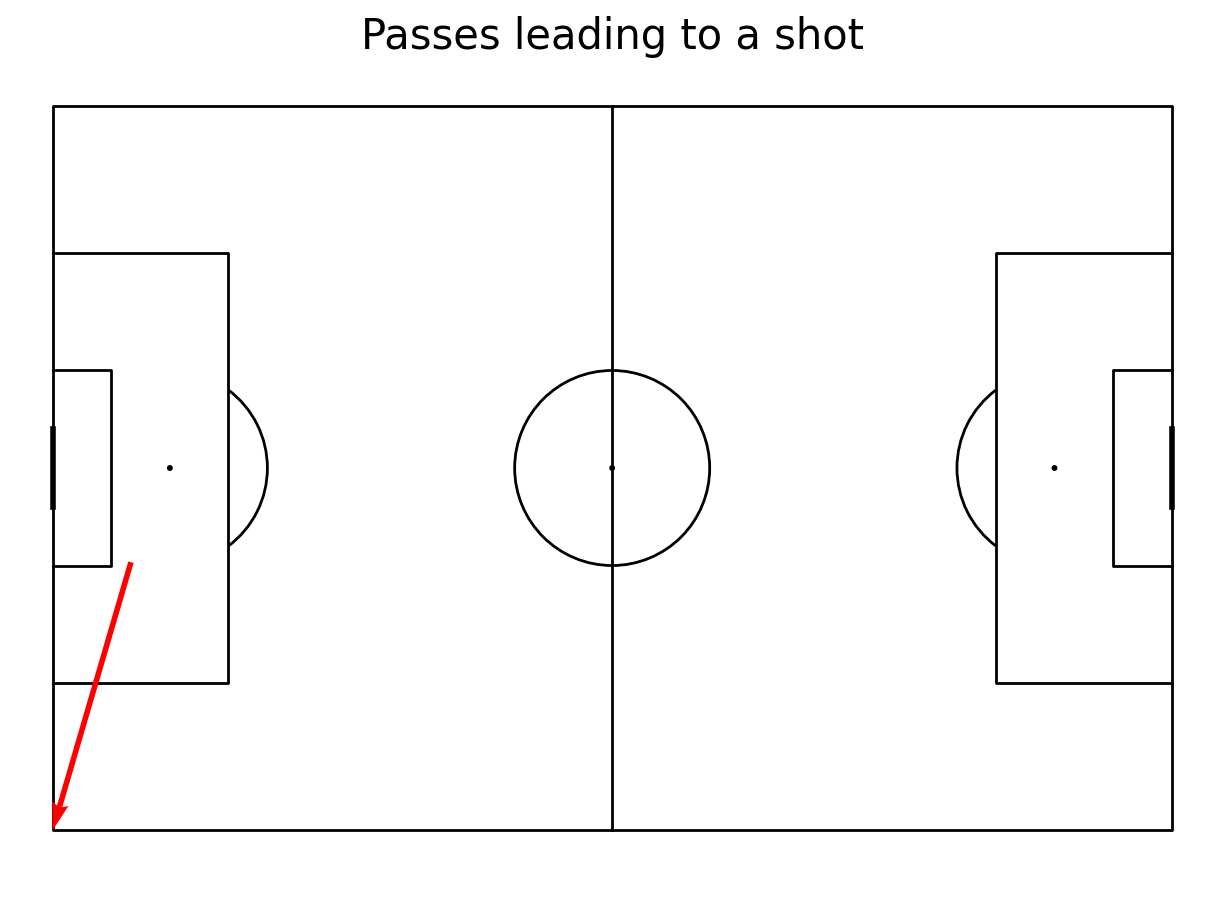

In [33]:
#plot possesion chain that ended with shot
chain = df.loc[df["possesion_chain"] == 13]
#get passes
passes = chain.loc[chain["eventName"].isin(["Pass"])]
#get events different than pass
not_pass = chain.loc[chain["eventName"] != "Pass"].iloc[:-1]
#shot is the last event of the chain (or should be)
shot = chain.iloc[-1]
#plot 
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#passes
pitch.arrows(passes.x0, passes.y0,
            passes.x1, passes.y1, color = "blue", ax=ax['pitch'], zorder =  3)
#shot
pitch.arrows(shot.x0, shot.y0,
            shot.x1, shot.y1, color = "red", ax=ax['pitch'], zorder =  3)
#other passes like arrows
pitch.lines(not_pass.x0, not_pass.y0, not_pass.x1, not_pass.y1, color = "grey", lw = 1.5, ls = 'dotted', ax=ax['pitch'])
ax['title'].text(0.5, 0.5, 'Passes leading to a shot', ha='center', va='center', fontsize=30)
plt.show()

In [34]:
df[df['shot_end']== 1]

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,...,possesion_chain,possesion_chain_team,xG,shot_end,x0,c0,x1,c1,y0,y1
25,8,Simple pass,[{'id': 1801}],3560,"[{'y': 74, 'x': 19}, {'y': 53, 'x': 4}]",2499719,Pass,1609,1H,43.045831,...,3,1609,0.137573,1,19.95,16.32,4.20,2.04,17.68,31.96
26,8,Launch,[{'id': 1801}],7882,"[{'y': 53, 'x': 4}, {'y': 44, 'x': 40}]",2499719,Pass,1609,1H,44.425679,...,3,1609,0.137573,1,4.20,2.04,42.00,4.08,31.96,38.08
30,1,Ground attacking duel,"[{'id': 503}, {'id': 703}, {'id': 1801}]",7945,"[{'y': 51, 'x': 44}, {'y': 46, 'x': 55}]",2499719,Duel,1609,1H,50.337521,...,3,1609,0.137573,1,46.20,0.68,57.75,2.72,33.32,36.72
31,1,Ground attacking duel,"[{'id': 501}, {'id': 703}, {'id': 1801}]",7945,"[{'y': 46, 'x': 55}, {'y': 44, 'x': 64}]",2499719,Duel,1609,1H,51.665811,...,3,1609,0.137573,1,57.75,2.72,67.20,4.08,36.72,38.08
34,1,Ground attacking duel,"[{'id': 501}, {'id': 703}, {'id': 1801}]",7945,"[{'y': 44, 'x': 64}, {'y': 52, 'x': 64}]",2499719,Duel,1609,1H,53.253798,...,3,1609,0.137573,1,67.20,4.08,67.20,1.36,38.08,32.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643051,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1201}, {'id'...",7879,"[{'y': 62, 'x': 88}, {'y': 100, 'x': 100}]",2500098,Shot,1623,2H,2377.197700,...,113366,1623,0.116724,1,92.40,8.16,105.00,0.00,25.84,34.00
643055,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1206}, {'id'...",145692,"[{'y': 38, 'x': 92}, {'y': 100, 'x': 100}]",2500098,Shot,1623,2H,2381.481625,...,113367,1633,0.170976,1,96.60,8.16,105.00,0.00,42.16,34.00
643146,3,Corner,"[{'id': 302}, {'id': 801}, {'id': 1801}]",70965,"[{'y': 100, 'x': 100}, {'y': 47, 'x': 88}]",2500098,Free Kick,1633,2H,2829.821084,...,113382,1633,0.038676,1,105.00,34.00,92.40,2.04,0.00,36.04
643148,1,Air duel,"[{'id': 703}, {'id': 1801}]",8005,"[{'y': 47, 'x': 88}, {'y': 50, 'x': 86}]",2500098,Duel,1633,2H,2832.434399,...,113382,1633,0.038676,1,92.40,2.04,90.30,0.00,36.04,34.00


## Possesion chain that did not end with a shot

And here is a one that did not end with a shot. 



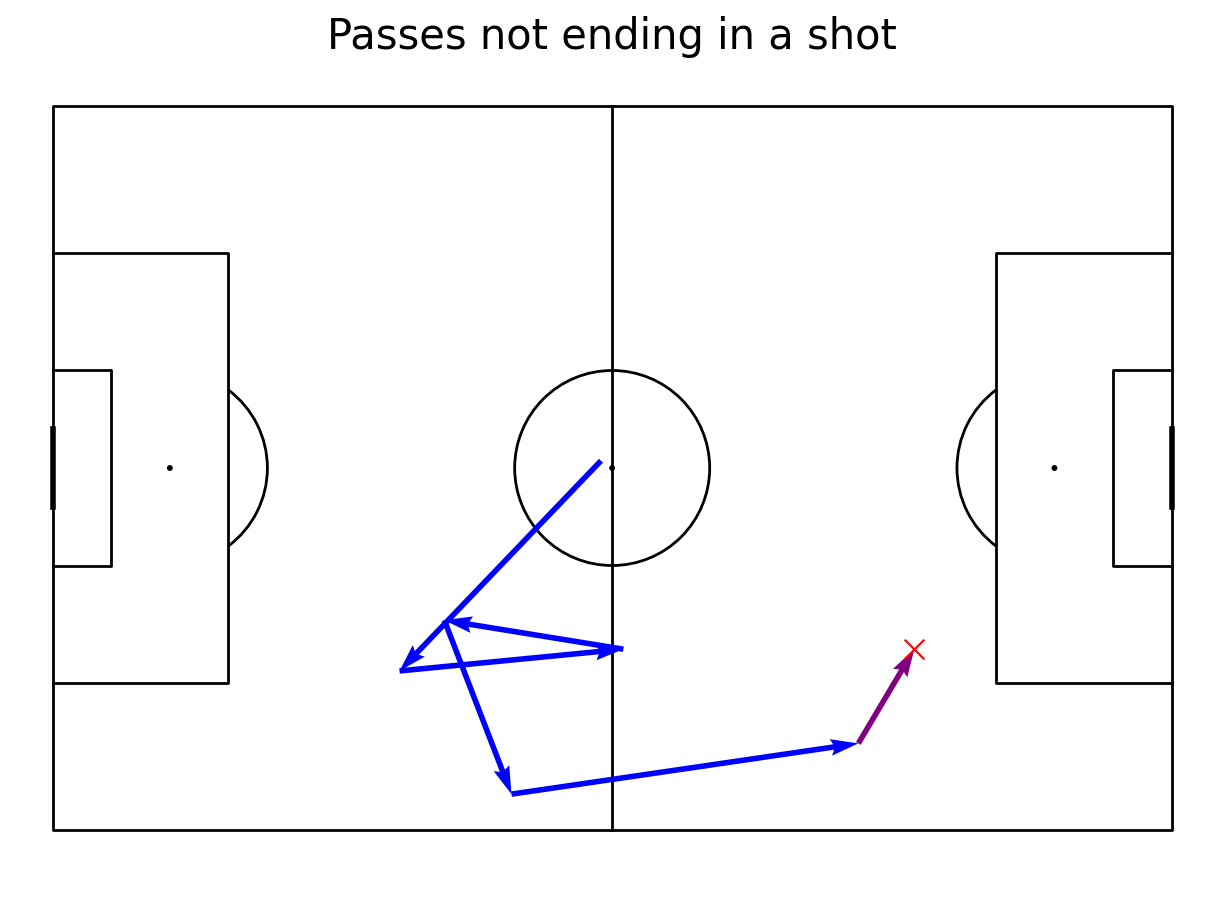

In [35]:
#plot possesion chain that ended with shot
chain = df.loc[df["possesion_chain"] == 0]
passes = chain.loc[chain["eventName"].isin(["Pass", "Free Kick"])].iloc[:-1]
not_pass = chain.loc[(chain["eventName"] != "Pass") & (chain["eventName"] != "Free Kick")].iloc[:-1]
bad_pass = chain.iloc[-1]
#we could have used better 
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pitch.arrows(passes.x0, passes.y0,
            passes.x1, passes.y1, color = "blue", ax=ax['pitch'], zorder =  3)
pitch.arrows(bad_pass.x0, bad_pass.y0,
            bad_pass.x1, bad_pass.y1, color = "purple", ax=ax['pitch'], zorder =  3)
pitch.scatter(bad_pass.x1, bad_pass.y1, marker = 'x', color = "red", ax=ax['pitch'], zorder =  3, s= 200)
pitch.lines(not_pass.x0, not_pass.y0, not_pass.x1, not_pass.y1, color = "grey", lw = 1.5, ls = 'dotted', ax=ax['pitch'])
ax['title'].text(0.5, 0.5, 'Passes not ending in a shot', ha='center', va='center', fontsize=30)
plt.show()

In [36]:
chain

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,...,possesion_chain,possesion_chain_team,xG,shot_end,x0,c0,x1,c1,y0,y1
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,...,0,1609,0.0,0,51.45,0.68,32.55,19.04,34.68,14.96
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,...,0,1609,0.0,0,32.55,19.04,53.55,17.00,14.96,17.00
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,...,0,1609,0.0,0,53.55,17.00,36.75,14.28,17.00,19.72
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,...,0,1609,0.0,0,36.75,14.28,43.05,30.60,19.72,3.40
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,...,0,1609,0.0,0,43.05,30.60,75.60,25.84,3.40,8.16
5,8,Simple pass,[{'id': 1802}],3319,"[{'y': 88, 'x': 72}, {'y': 75, 'x': 77}]",2499719,Pass,1609,1H,12.548934,...,0,1609,0.0,0,75.60,25.84,80.85,17.00,8.16,17.00


In [37]:
len(df)

435134

In [38]:
#df.to_json('possession_chains_France.json', orient='columns')

In [39]:
pwd

'/Users/jamesdavies/soccermatics/4_valuing_actions'